<a href="https://colab.research.google.com/github/VNagaHarshitha/SentimentAnalysisProject/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from prophet import Prophet
from google.colab import userdata

In [ ]:
CSV_FILE = "combined_news_sentiment_with_url.csv"  # your existing file in Colab
SLACK_WEBHOOK = userdata.get('SLACK_WEBHOOK')  # Slack webhook stored in Colab secrets
POSITIVE_THRESHOLD = 5.0
NEGATIVE_THRESHOLD = -5.0
# ----------------- LOAD CSV -----------------
df = pd.read_csv(CSV_FILE)
df.columns = df.columns.str.strip().str.lower()  # normalize column names

if "sentiment_score" not in df.columns:
    raise ValueError("CSV must contain a 'sentiment_score' column")


In [ ]:
# ----------------- FUNCTION TO SEND SLACK ALERT -----------------
def send_slack_alert(message: str):
    if not SLACK_WEBHOOK:
        print("⚠ Slack Webhook URL not set in Colab secrets.")
        return
    payload = {"text": message}
    try:
        r = requests.post(SLACK_WEBHOOK, json=payload)
        if r.status_code == 200:
            print("✅ Slack alert sent:", message)
        else:
            print(f"⚠ Failed to send Slack alert: {r.status_code}, {r.text}")
    except Exception as e:
        print("⚠ Slack alert error:", e)

# ----------------- SEND ALERTS BASED ON SENTIMENT -----------------
for i, row in df.iterrows():
    score = row["sentiment_score"]
    title = row.get("title", "No Title")

    if score > POSITIVE_THRESHOLD:
        send_slack_alert(f"✅ Positive Alert: Sentiment score {score:.2f} for '{title}'")
    elif score < NEGATIVE_THRESHOLD:
        send_slack_alert(f"🔴 Negative Alert: Sentiment score {score:.2f} for '{title}'")

print("✅ All alerts processed.")

✅ Slack alert sent: ✅ Positive Alert: Sentiment score 6.17 for 'Jim Cramer Calls Bloom Energy “One of the Great Success Stories of This Remarkable Era”'
✅ Slack alert sent: 🔴 Negative Alert: Sentiment score -10.00 for 'Michael Saylor Says Bitcoin May Go ‘Boring’ as Institutional Money Kills Volatility'
✅ Slack alert sent: 🔴 Negative Alert: Sentiment score -10.00 for 'This Boring Blue-Chip Stock Could Be the Winner in Quantum Computing. Should You Buy Its Shares Here?'
✅ Slack alert sent: ✅ Positive Alert: Sentiment score 10.00 for 'Are Magnificent 7 stocks overpriced? Here are alternatives.'
✅ Slack alert sent: ✅ Positive Alert: Sentiment score 8.00 for 'From Retail Darling to AI Powerhouse, This $2.4 trillion Growth Stock Is a Great Buy'
✅ Slack alert sent: ✅ Positive Alert: Sentiment score 6.43 for 'I review gaming handhelds for a living – here are the best 3 you can buy right now'
✅ Slack alert sent: 🔴 Negative Alert: Sentiment score -10.00 for 'This Boring Blue-Chip Stock Could Be 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvz3v00ch/6134y__8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvz3v00ch/337xlfhs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40645', 'data', 'file=/tmp/tmpvz3v00ch/6134y__8.json', 'init=/tmp/tmpvz3v00ch/337xlfhs.json', 'output', 'file=/tmp/tmpvz3v00ch/prophet_modelwow0fyyl/prophet_model-20250922124833.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:48:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:48:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


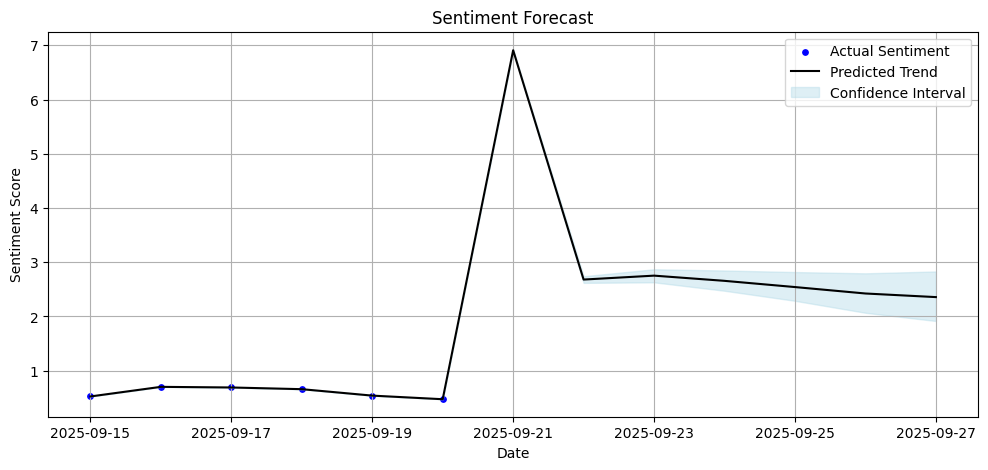

In [ ]:


# ----------------- FORECASTING WITH PROPHET -----------------
# Ensure datetime conversion
if "publishedat" not in df.columns:
    raise ValueError("CSV must contain a 'publishedAt' column with dates")

df["publishedat"] = pd.to_datetime(df["publishedat"], errors="coerce").dt.tz_localize(None)
df = df.dropna(subset=["publishedat"])

# Aggregate daily sentiment
daily_df = df.resample("D", on="publishedat")["sentiment_score"].mean().reset_index()
daily_df = daily_df.rename(columns={"publishedat": "ds", "sentiment_score": "y"})

# Optional: smooth slightly
daily_df["y"] = daily_df["y"].rolling(window=3, min_periods=1).mean()

# Fit Prophet model
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(daily_df)

# Forecast 7 days
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

# Plot results
plt.figure(figsize=(12,5))
plt.scatter(daily_df["ds"], daily_df["y"], color="blue", label="Actual Sentiment", s=15)
plt.plot(forecast["ds"], forecast["yhat"], color="black", label="Predicted Trend")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"],
                 color="lightblue", alpha=0.4, label="Confidence Interval")
plt.title("Sentiment Forecast")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True)
plt.show()
